# Comparison of CPU and GPU Solvers for Adapted Wasserstein Distance
 
**Overview:**  
This notebook compares the precision and speed between the CPU solver and the fully vectorized GPU solver for computing the adapted Wasserstein squared distance.
 
**Setup:**  
- **Sample Sizes:** [500, 1000, 2000, 3000, 4000, 5000]  
- **Runs per Sample Size:** 10  
- **Fixed Grid:** 0.05  
- **Time Horizon:** T = 3  
- **Matrices:**  
  $$
  L = \begin{pmatrix}1 & 0 & 0 \\ 2 & 4 & 0 \\ 3 & 2 & 1\end{pmatrix},\quad
  M = \begin{pmatrix}1 & 0 & 0 \\ 2 & 3 & 0 \\ 3 & 1 & 2\end{pmatrix}.
  $$
 
The notebook uses your imported functions (from your module files) for path generation, adapted quantization, conditional measure construction, and the two solvers.
 
**Outputs:**  
- Aggregated results for both CPU and GPU (mean AW₂², computation time, and absolute difference between CPU and GPU AW₂²)  
- Publication-ready plots for speed and precision comparison.

In [3]:
import os, sys, numpy as np, time, random, torch
import matplotlib.pyplot as plt

# Set up module paths (adjust as needed)
notebooks_path = os.path.abspath(os.getcwd())
src_path = os.path.abspath(os.path.join(notebooks_path, "../src"))
if src_path not in sys.path:
    sys.path.insert(0, src_path)

# Import your custom functions (assumed available in your module)
from solver import *
from optimal_solver_gpu import *

In [5]:
sample_sizes = [500, 1000, 2000, 3000, 4000, 5000]
n_runs = 10
fixed_grid = 0.1
T = 3

# Define the matrices
L = np.array([[1, 0, 0],
              [2, 4, 0],
              [3, 2, 1]])
M = np.array([[1, 0, 0],
              [2, 3, 0],
              [3, 1, 2]])

In [6]:
# Prepare dictionaries to store results
results_cpu = {}
results_gpu = {}

# Loop over sample sizes
for n_sample in sample_sizes:
    cpu_aw2 = np.zeros(n_runs)
    cpu_times = np.zeros(n_runs)
    
    gpu_aw2 = np.zeros(n_runs)
    gpu_times = np.zeros(n_runs)
    
    print(f"\nSample size: {n_sample}")
    for run in range(n_runs):
        # Use a random seed for each run
        seed = np.random.randint(10000)
        
        # Generate sample paths for X and Y
        X, A = Lmatrix2paths(L, n_sample, seed=seed, verbose=False)
        Y, B = Lmatrix2paths(M, n_sample, seed=seed, verbose=False)
        
        # Compute theoretical benchmark (not used further but can be printed)
        # dist_bench = adapted_wasserstein_squared(A, B)
        # print("Theoretical AW_2^2: ", dist_bench)
        
        # Compute adapted paths using grid quantization (delta_n = 0.05)
        adaptedX = path2adaptedpath(X, delta_n=fixed_grid)
        adaptedY = path2adaptedpath(Y, delta_n=fixed_grid)
        
        # Create quantization mapping
        q2v = np.unique(np.concatenate([adaptedX, adaptedY], axis=0))
        v2q = {k: v for v, k in enumerate(q2v)}
        
        # Quantize the paths
        qX = np.array([[v2q[x] for x in y] for y in adaptedX])
        qY = np.array([[v2q[x] for x in y] for y in adaptedY])
        
        # Sort the quantized paths and transpose to (n_sample, T+1)
        qX = sort_qpath(qX.T)
        qY = sort_qpath(qY.T)
        
        # Compute conditional measures for X and Y
        mu_x = qpath2mu_x(qX)
        nu_y = qpath2mu_x(qY)
        
        # Represent the conditional measures
        mu_x_c, mu_x_cn, mu_x_v, mu_x_w, mu_x_cumn = list_repr_mu_x(mu_x, q2v)
        nu_y_c, nu_y_cn, nu_y_v, nu_y_w, nu_y_cumn = list_repr_mu_x(nu_y, q2v)
        
        # ---- CPU Solver ----
        start_cpu = time.perf_counter()
        AW_2square_cpu = nested2_parallel(mu_x_cn, mu_x_v, mu_x_w, mu_x_cumn,
                                          nu_y_cn, nu_y_v, nu_y_w, nu_y_cumn)
        end_cpu = time.perf_counter()
        cpu_aw2[run] = AW_2square_cpu
        cpu_times[run] = end_cpu - start_cpu
        
        # ---- GPU Solver (if available) ----
        if torch.cuda.is_available():
            device = torch.device("cuda")
            recursion_data = []
            # For each time step, pad the variable-length lists and build GPU tensors
            for t in range(len(mu_x_v)):
                x_v_list = mu_x_v[t]
                x_w_list = mu_x_w[t]
                y_v_list = nu_y_v[t]
                y_w_list = nu_y_w[t]
                
                max_x_len = max(len(v) for v in x_v_list)
                max_y_len = max(len(v) for v in y_v_list)
                
                x_v_tensor = torch.zeros((len(x_v_list), max_x_len), dtype=torch.float32, device=device)
                x_w_tensor = torch.zeros_like(x_v_tensor)
                x_len_tensor = torch.tensor([len(v) for v in x_v_list], dtype=torch.long, device=device)
                
                y_v_tensor = torch.zeros((len(y_v_list), max_y_len), dtype=torch.float32, device=device)
                y_w_tensor = torch.zeros_like(y_v_tensor)
                y_len_tensor = torch.tensor([len(v) for v in y_v_list], dtype=torch.long, device=device)
                
                for i, (vx, wx) in enumerate(zip(x_v_list, x_w_list)):
                    x_v_tensor[i, :len(vx)] = torch.tensor(vx, dtype=torch.float32, device=device)
                    x_w_tensor[i, :len(wx)] = torch.tensor(wx, dtype=torch.float32, device=device)
                for i, (vy, wy) in enumerate(zip(y_v_list, y_w_list)):
                    y_v_tensor[i, :len(vy)] = torch.tensor(vy, dtype=torch.float32, device=device)
                    y_w_tensor[i, :len(wy)] = torch.tensor(wy, dtype=torch.float32, device=device)
                
                recursion_data.append((x_v_tensor, x_w_tensor, x_len_tensor,
                                       y_v_tensor, y_w_tensor, y_len_tensor))
            
            torch.cuda.synchronize()
            start_gpu = time.perf_counter()
            AW_2square_gpu = nested2_parallel_gpu_fully_batched_all_vectorized(
                recursion_data,
                lambda_reg=5.0,
                stopping_criterion=1e-6,
                max_iterations=500,
            )
            torch.cuda.synchronize()
            end_gpu = time.perf_counter()
            gpu_aw2[run] = AW_2square_gpu.item()
            gpu_times[run] = end_gpu - start_gpu
        else:
            gpu_aw2[run] = np.nan
            gpu_times[run] = np.nan
        
        print(f"Run {run+1}: CPU AW2^2 = {AW_2square_cpu:.4f} in {cpu_times[run]:.4f}s; " + 
              (f"GPU AW2^2 = {gpu_aw2[run]:.4f} in {gpu_times[run]:.4f}s" if torch.cuda.is_available() else "GPU not available"))
    
    results_cpu[n_sample] = {"aw2": cpu_aw2, "times": cpu_times}
    results_gpu[n_sample] = {"aw2": gpu_aw2, "times": gpu_times}


Sample size: 500
Processing time step 2 ...
Processing time step 1 ...
Processing time step 0 ...
Run 1: CPU AW2^2 = 2.9606 in 29.5256s; GPU AW2^2 = 2.9398 in 3.7018s
Processing time step 2 ...
Processing time step 1 ...
Processing time step 0 ...
Run 2: CPU AW2^2 = 3.1244 in 25.3217s; GPU AW2^2 = 3.0919 in 2.1879s
Processing time step 2 ...
Processing time step 1 ...
Processing time step 0 ...
Run 3: CPU AW2^2 = 3.0424 in 24.5341s; GPU AW2^2 = 3.0361 in 1.3481s
Processing time step 2 ...
Processing time step 1 ...
Processing time step 0 ...
Run 4: CPU AW2^2 = 3.3487 in 25.7156s; GPU AW2^2 = 3.3386 in 1.0973s
Processing time step 2 ...
Processing time step 1 ...
Processing time step 0 ...
Run 5: CPU AW2^2 = 3.2581 in 25.2698s; GPU AW2^2 = 3.2215 in 1.2043s
Processing time step 2 ...
Processing time step 1 ...
Processing time step 0 ...
Run 6: CPU AW2^2 = 3.2795 in 23.3403s; GPU AW2^2 = 3.1881 in 1.0720s
Processing time step 2 ...
Processing time step 1 ...
Processing time step 0 ...
R

KeyboardInterrupt: 

In [7]:
agg_sample = sorted(results_cpu.keys())
cpu_aw2_mean = []
cpu_aw2_std = []
cpu_time_mean = []
cpu_time_std = []

gpu_aw2_mean = []
gpu_aw2_std = []
gpu_time_mean = []
gpu_time_std = []

abs_diff_mean = []
abs_diff_std = []

for n_sample in agg_sample:
    cpu_aw = results_cpu[n_sample]["aw2"]
    cpu_t = results_cpu[n_sample]["times"]
    gpu_aw = results_gpu[n_sample]["aw2"]
    gpu_t = results_gpu[n_sample]["times"]
    
    cpu_aw2_mean.append(np.mean(cpu_aw))
    cpu_aw2_std.append(np.std(cpu_aw))
    cpu_time_mean.append(np.mean(cpu_t))
    cpu_time_std.append(np.std(cpu_t))
    
    gpu_aw2_mean.append(np.mean(gpu_aw))
    gpu_aw2_std.append(np.std(gpu_aw))
    gpu_time_mean.append(np.mean(gpu_t))
    gpu_time_std.append(np.std(gpu_t))
    
    # Compute absolute difference only if GPU is available (i.e. not NaN)
    diff = np.abs(np.array(cpu_aw) - np.array(gpu_aw))
    abs_diff_mean.append(np.mean(diff))
    abs_diff_std.append(np.std(diff))
    
    print(f"Sample Size {n_sample}:")
    print(f"  CPU:   AW2^2 = {np.mean(cpu_aw):.4f} ± {np.std(cpu_aw):.4f}, Time = {np.mean(cpu_t):.4f}s ± {np.std(cpu_t):.4f}s")
    if not np.isnan(gpu_aw).all():
        print(f"  GPU:   AW2^2 = {np.mean(gpu_aw):.4f} ± {np.std(gpu_aw):.4f}, Time = {np.mean(gpu_t):.4f}s ± {np.std(gpu_t):.4f}s")
        print(f"  Abs Diff (CPU vs GPU AW2^2): {np.mean(diff):.4e} ± {np.std(diff):.4e}")
    else:
        print("  GPU not available.")
    print()

Sample Size 500:
  CPU:   AW2^2 = 3.1788 ± 0.1348, Time = 24.6321s ± 1.9102s
  GPU:   AW2^2 = 3.1505 ± 0.1348, Time = 1.4909s ± 0.8070s
  Abs Diff (CPU vs GPU AW2^2): 3.1292e-02 ± 2.6074e-02

Sample Size 1000:
  CPU:   AW2^2 = 3.2087 ± 0.1169, Time = 24.8823s ± 0.5316s
  GPU:   AW2^2 = 3.1136 ± 0.1116, Time = 2.7582s ± 0.1276s
  Abs Diff (CPU vs GPU AW2^2): 9.5132e-02 ± 2.8729e-02

Sample Size 2000:
  CPU:   AW2^2 = 3.2932 ± 0.0814, Time = 31.6720s ± 1.4046s
  GPU:   AW2^2 = 3.0996 ± 0.0688, Time = 6.8074s ± 0.3980s
  Abs Diff (CPU vs GPU AW2^2): 1.9365e-01 ± 2.9419e-02

Sample Size 3000:
  CPU:   AW2^2 = 3.3825 ± 0.0618, Time = 41.9775s ± 0.8412s
  GPU:   AW2^2 = 3.1549 ± 0.0739, Time = 52.1699s ± 39.9671s
  Abs Diff (CPU vs GPU AW2^2): 2.2759e-01 ± 3.1015e-02

Sample Size 4000:
  CPU:   AW2^2 = 3.3771 ± 0.0547, Time = 103.6859s ± 36.0198s
  GPU:   AW2^2 = 3.1369 ± 0.0571, Time = 202.4386s ± 21.4405s
  Abs Diff (CPU vs GPU AW2^2): 2.4019e-01 ± 2.9346e-02



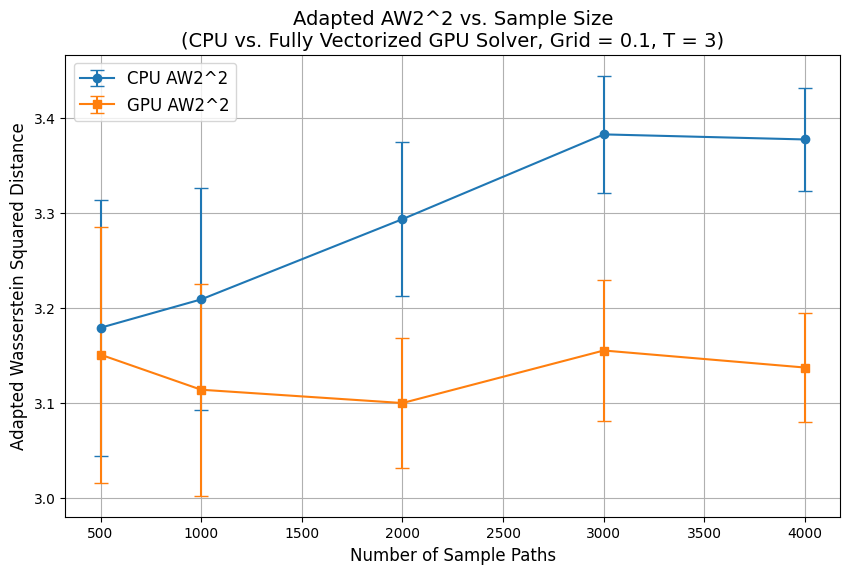

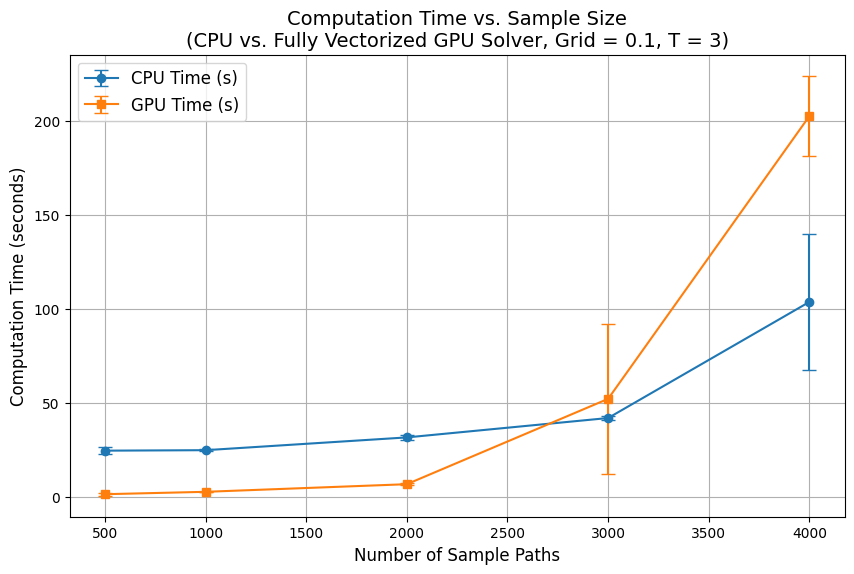

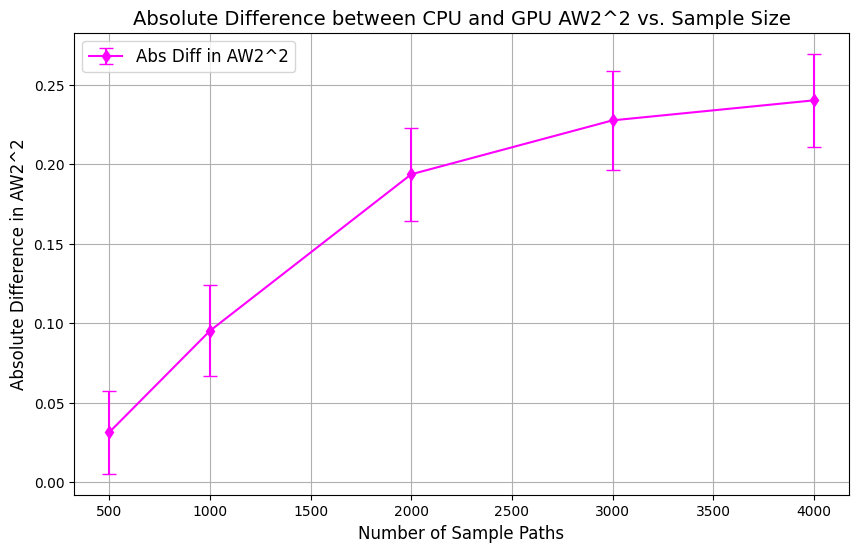

In [8]:
plt.figure(figsize=(10, 6))
plt.errorbar(agg_sample, cpu_aw2_mean, yerr=cpu_aw2_std, fmt="o-", capsize=5, label="CPU AW2^2")
if torch.cuda.is_available():
    plt.errorbar(agg_sample, gpu_aw2_mean, yerr=gpu_aw2_std, fmt="s-", capsize=5, label="GPU AW2^2")
plt.xlabel("Number of Sample Paths", fontsize=12)
plt.ylabel("Adapted Wasserstein Squared Distance", fontsize=12)
plt.title("Adapted AW2^2 vs. Sample Size\n(CPU vs. Fully Vectorized GPU Solver, Grid = 0.1, T = 3)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Plot 2: Computation Time vs. Sample Size
plt.figure(figsize=(10, 6))
plt.errorbar(agg_sample, cpu_time_mean, yerr=cpu_time_std, fmt="o-", capsize=5, label="CPU Time (s)")
if torch.cuda.is_available():
    plt.errorbar(agg_sample, gpu_time_mean, yerr=gpu_time_std, fmt="s-", capsize=5, label="GPU Time (s)")
plt.xlabel("Number of Sample Paths", fontsize=12)
plt.ylabel("Computation Time (seconds)", fontsize=12)
plt.title("Computation Time vs. Sample Size\n(CPU vs. Fully Vectorized GPU Solver, Grid = 0.1, T = 3)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Plot 3: Absolute Difference in AW2^2 (CPU vs. GPU) vs. Sample Size
if torch.cuda.is_available():
    plt.figure(figsize=(10, 6))
    plt.errorbar(agg_sample, abs_diff_mean, yerr=abs_diff_std, fmt="d-", capsize=5, color="magenta", label="Abs Diff in AW2^2")
    plt.xlabel("Number of Sample Paths", fontsize=12)
    plt.ylabel("Absolute Difference in AW2^2", fontsize=12)
    plt.title("Absolute Difference between CPU and GPU AW2^2 vs. Sample Size", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()